In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


## Loading train data

In [3]:
df_train = pd.read_csv("/resources/data/brainwaves/train.csv")
df_test = pd.read_csv("/resources/data/brainwaves/test.csv")
#df.head()
df_test.isnull().sum()


portfolio_id         0
desk_id           1948
office_id            0
pf_category          0
start_date           0
sold                 0
country_code         0
euribor_rate         0
currency             0
libor_rate         265
bought               0
creation_date        0
indicator_code    2851
sell_date            0
type                 0
hedge_value       2851
status            1457
dtype: int64

## Finding correlation between raw features

In [4]:
df_train.corr()

,start_date,sold,euribor_rate,libor_rate,bought,creation_date,sell_date,return
start_date,1.000000,-0.124866,-0.755212,-0.727701,-0.124432,0.999977,0.997442,-0.504295
sold,-0.124866,1.000000,0.184441,0.114494,0.999999,-0.124850,-0.127505,0.086938
euribor_rate,-0.755212,0.184441,1.000000,0.804120,0.183944,-0.755203,-0.754965,0.648551
libor_rate,-0.727701,0.114494,0.804120,1.000000,0.113923,-0.727665,-0.724785,0.701278
bought,-0.124432,0.999999,0.183944,0.113923,1.000000,-0.124415,-0.127078,0.086353
creation_date,0.999977,-0.124850,-0.755203,-0.727665,-0.124415,1.000000,0.997421,-0.504261
sell_date,0.997442,-0.127505,-0.754965,-0.724785,-0.127078,0.997421,1.000000,-0.503353
return,-0.504295,0.086938,0.648551,0.701278,0.086353,-0.504261,-0.503353,1.000000


In [5]:
df_train.columns

Index([u'portfolio_id', u'desk_id', u'office_id', u'pf_category',
       u'start_date', u'sold', u'country_code', u'euribor_rate', u'currency',
       u'libor_rate', u'bought', u'creation_date', u'indicator_code',
       u'sell_date', u'type', u'hedge_value', u'status', u'return'],
      dtype='object')

## Combining train and test datasets for pre-processing

In [6]:
#joining test and train datasets
df= pd.concat([df_train, df_test], axis=0, join='outer')

## Feature Engineering

In [7]:
df_train.loc[:,['office_id', 'country_code']].head()

,office_id,country_code
0,OFF00001002,T
1,OFF00001001,N
2,OFF00001001,T
3,OFF00001001,T
4,OFF00001002,T


In [8]:
#filling missing libor rate values with the mean of libor rate
df['libor_rate'].fillna(df['libor_rate'].mean(), inplace=True)

In [9]:
df['profit'] = df['sold'] - df['bought']
df['sell_date'] =pd.to_datetime(df['sell_date'] , format='%Y%m%d', errors='ignore')
df['start_date'] =pd.to_datetime(df['start_date'] , format='%Y%m%d', errors='ignore')

import datetime as dt
df['holding_period'] = (df['sell_date'] - 
                              df['start_date']).dt.days
#df_train.corr()

df['interest'] = df['bought']*(df['holding_period']/30)*(df['libor_rate'])/100
df['interest']
df.corr()

,bought,creation_date,euribor_rate,libor_rate,return,sold,profit,holding_period,interest
bought,1.000000,-0.140151,0.210422,0.120805,0.086353,0.999999,0.258676,-0.137848,0.226129
creation_date,-0.140151,1.000000,-0.755112,-0.723239,-0.504261,-0.140600,-0.347486,0.131104,-0.336553
euribor_rate,0.210422,-0.755112,1.000000,0.800831,0.648551,0.210947,0.418994,-0.122452,0.377244
libor_rate,0.120805,-0.723239,0.800831,1.000000,0.590431,0.121397,0.442434,0.033549,0.500406
return,0.086353,-0.504261,0.648551,0.590431,1.000000,0.086938,0.455079,-0.037753,0.270207
sold,0.999999,-0.140600,0.210947,0.121397,0.086938,1.000000,0.260020,-0.137588,0.227114
profit,0.258676,-0.347486,0.418994,0.442434,0.455079,0.260020,1.000000,0.144069,0.742145
holding_period,-0.137848,0.131104,-0.122452,0.033549,-0.037753,-0.137588,0.144069,1.000000,0.228173
interest,0.226129,-0.336553,0.377244,0.500406,0.270207,0.227114,0.742145,0.228173,1.000000


## Replacing NaN values

In [10]:
#df=df_train.append(df_test)
df.head()

,bought,country_code,creation_date,currency,desk_id,euribor_rate,hedge_value,indicator_code,libor_rate,office_id,...,portfolio_id,return,sell_date,sold,start_date,status,type,profit,holding_period,interest
0,1.098097e+08,T,20040720,USD,DSK00001001,0.02074,NaN,NaN,2.332216,OFF00001002,...,PF00001002,0.02496,2004-08-12,110000000.0,2004-07-20,NaN,B,190336.749636,23,1.963432e+06
1,1.760084e+08,N,20040723,GBP,DSK00001002,0.02074,NaN,NaN,5.269617,OFF00001001,...,PF00001003,0.05496,2004-08-12,176671000.0,2004-07-09,NaN,C,662563.265958,34,1.051163e+07
2,5.637953e+07,T,20040723,USD,DSK00001004,0.02074,NaN,NaN,2.332216,OFF00001001,...,PF00001005,0.02496,2004-08-17,56474000.0,2004-07-23,NaN,A,94467.039667,25,1.095744e+06
3,1.645088e+08,T,20040723,USD,DSK00001005,0.02074,NaN,NaN,2.332216,OFF00001001,...,PF00001006,0.02496,2004-07-13,164813000.0,2004-06-09,NaN,A,304158.569044,34,4.348262e+06
4,1.405402e+08,T,20040723,USD,DSK00001005,0.02074,NaN,NaN,2.332216,OFF00001002,...,PF00001007,0.02496,2004-07-13,140800000.0,2004-06-09,NaN,B,259843.134474,34,3.714727e+06


In [11]:
df['indicator_code'].fillna(False, inplace=True)
df['hedge_value'].fillna(-1, inplace=True)
df['status'].fillna(-1, inplace=True)

set(df['status'])
df['status'].value_counts()


True    9626
-1      4541
Name: status, dtype: int64

## Label Encoding Categorical Variables

In [12]:
label_enc = LabelEncoder()
df['pf_category']=label_enc.fit_transform(df['pf_category'])
df['country_code']=label_enc.fit_transform(df['country_code'])
df['currency']=label_enc.fit_transform(df['currency'])
df['indicator_code']=label_enc.fit_transform(df['indicator_code'])
df['type']=label_enc.fit_transform(df['type'])
df['hedge_value']=label_enc.fit_transform(df['hedge_value'])
df['status']=label_enc.fit_transform(df['status'])
#set(df['indicator_code'])


## One Hot Encoding

In [13]:
df_new = pd.get_dummies(df, columns=['pf_category', 'country_code', 'currency','indicator_code', 'type','hedge_value','status'])


## Checking NaNs

In [14]:

df_new.isnull().sum()


bought                 2
creation_date          0
desk_id             5613
euribor_rate           0
libor_rate             0
office_id              0
portfolio_id           0
return              4801
sell_date              0
sold                   2
start_date             0
profit                 2
holding_period         0
interest               2
pf_category_0          0
pf_category_1          0
pf_category_2          0
pf_category_3          0
pf_category_4          0
country_code_0         0
country_code_1         0
country_code_2         0
country_code_3         0
country_code_4         0
currency_0             0
currency_1             0
currency_2             0
currency_3             0
currency_4             0
indicator_code_0       0
indicator_code_1       0
type_0                 0
type_1                 0
type_2                 0
type_3                 0
type_4                 0
type_5                 0
type_6                 0
type_7                 0
hedge_value_0          0


## Splitting train and test dataset

In [15]:
df_train = df_new.iloc[:9366,:]
df_test = df_new.iloc[9366:,:]

## Preparing train dataset

In [16]:
#removing nans
df_train.dropna(axis=0, subset=['sold', 'bought'], inplace=True)
df_train.isnull().sum()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


bought                 0
creation_date          0
desk_id             3665
euribor_rate           0
libor_rate             0
office_id              0
portfolio_id           0
return                 0
sell_date              0
sold                   0
start_date             0
profit                 0
holding_period         0
interest               0
pf_category_0          0
pf_category_1          0
pf_category_2          0
pf_category_3          0
pf_category_4          0
country_code_0         0
country_code_1         0
country_code_2         0
country_code_3         0
country_code_4         0
currency_0             0
currency_1             0
currency_2             0
currency_3             0
currency_4             0
indicator_code_0       0
indicator_code_1       0
type_0                 0
type_1                 0
type_2                 0
type_3                 0
type_4                 0
type_5                 0
type_6                 0
type_7                 0
hedge_value_0          0


In [17]:
X = df_train.loc[:,['sold',
       'euribor_rate', 'libor_rate', 'bought',
       'pf_category_0', 'pf_category_1',
       'pf_category_2', 'pf_category_3', 'pf_category_4', 'country_code_0',
       'country_code_1', 'country_code_2', 'country_code_3',
       'country_code_4', 'currency_0', 'currency_1', 'currency_2',
       'currency_3', 'currency_4', 'indicator_code_0', 'indicator_code_1',
       'type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
       'type_6', 'type_7', 'hedge_value_0', 'hedge_value_1',
       'hedge_value_2', 'status_0', 'status_1', 'holding_period', 'interest', 'profit']]
Y = df_train[ 'return']

#X=X.drop(labels=[572, 573],axis=0)
#Y=Y.drop(labels=[572, 573], axis=0)


## Creating CV

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X, Y,
                                        test_size=0.33, random_state=7)


## Creating CV (for test-like data) 

In [37]:
#X_test

## Building a baseline RF model

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators=300,max_leaf_nodes = 15,max_depth=4,
                              min_samples_leaf=11, min_samples_split= 20,
                              n_jobs=-1, random_state =7)

model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=15,
           min_impurity_split=1e-07, min_samples_leaf=11,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

In [23]:
#predicting
s=model.predict(X_test)
s

array([ 0.00436736,  0.00436736,  0.05194093, ...,  0.05801697,
        0.00410598,  0.05010096])

In [24]:
#evaluating R2 score
from sklearn.metrics import r2_score
r2_score (s, Y_test.values)

0.92872659725981044

In [25]:
#analyzing feature importances
model.feature_importances_

array([  6.45667259e-04,   9.22256576e-02,   1.63212066e-01,
         6.30755059e-04,   8.56014408e-04,   6.54150394e-04,
         2.20030304e-03,   1.97788779e-02,   0.00000000e+00,
         1.25170003e-03,   8.08856625e-04,   4.78485496e-03,
         0.00000000e+00,   3.07125593e-02,   1.76265642e-03,
         3.45262339e-02,   1.11325750e-03,   0.00000000e+00,
         5.06523343e-03,   0.00000000e+00,   0.00000000e+00,
         1.58916147e-04,   0.00000000e+00,   7.76940351e-04,
         0.00000000e+00,   9.63574535e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   6.20452995e-02,
         8.81051106e-02,   1.95714947e-03,   1.51366011e-02,
         4.70627564e-01])

## Prediction

In [27]:
df_test['return'] = model.predict(df_test.loc[:,[ 'sold',
       'euribor_rate', 'libor_rate', 'bought',
       'pf_category_0', 'pf_category_1',
       'pf_category_2', 'pf_category_3', 'pf_category_4', 'country_code_0',
       'country_code_1', 'country_code_2', 'country_code_3',
       'country_code_4', 'currency_0', 'currency_1', 'currency_2',
       'currency_3', 'currency_4', 'indicator_code_0', 'indicator_code_1',
       'type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
       'type_6', 'type_7', 'hedge_value_0', 'hedge_value_1',
       'hedge_value_2', 'status_0', 'status_1', 'holding_period', 'interest', 'profit']])
df_test.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bought,creation_date,desk_id,euribor_rate,libor_rate,office_id,portfolio_id,return,sell_date,sold,...,type_3,type_4,type_5,type_6,type_7,hedge_value_0,hedge_value_1,hedge_value_2,status_0,status_1
0,1.715337e+08,20040720,DSK00001001,0.02074,2.332216,OFF00001001,PF00001001,0.027951,2004-08-12,171831000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,5.638038e+07,20040723,DSK00001003,0.02074,2.332216,OFF00001002,PF00001004,0.042721,2004-07-19,56485000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,4.166179e+07,20040726,DSK00001007,0.02074,2.332216,OFF00001001,PF00001009,0.028118,2004-07-09,41734000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,8.250936e+07,20040726,DSK00001011,0.02074,2.332216,OFF00001001,PF00001013,0.027951,2004-10-19,82951000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,7.317055e+07,20040726,DSK00001012,0.02074,2.332216,OFF00001001,PF00001014,0.027951,2004-08-13,73293000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [28]:
df_pred = df_test.loc[:,['portfolio_id', 'return']]
df_pred.head()

,portfolio_id,return
0,PF00001001,0.027951
1,PF00001004,0.042721
2,PF00001009,0.028118
3,PF00001013,0.027951
4,PF00001014,0.027951


In [29]:
df_pred.to_csv('/resources/data/brainwaves/pred2.csv')

In [37]:
unimportant_features = ['pf_category_1', 'pf_category_2','pf_category_4', 
                 'country_code_1','country_code_3', 'currency_2', 'currency_3', 
                  'indicator_code_0', 'indicator_code_1','type_1', 'type_2',
                   'type_4','type_5','type_6', 
                 'type_7', 'hedge_value_0', 'hedge_value_1','hedge_value_2']

In [48]:

## model with important features
model1 = RandomForestRegressor(n_estimators=300,max_depth=5,
                              min_samples_leaf=100,n_jobs=-1)

model1.fit(X_train.drop(labels=unimportant_features, axis=1),Y_train)

#predicting
s1=model1.predict(X_test.drop(labels=unimportant_features, axis=1))

#evaluating R2 score
from sklearn.metrics import r2_score
r2_score (s, Y_test.values)


0.89503164635707755

## Plotting hyperparam graphs

In [20]:
model_new = RandomForestRegressor(random_state=7)


def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(model_new, param_grid = {parameter: num_range},
                               scoring=make_scorer(r2_score))
    grid_search.fit(X_train, Y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [21]:
# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(2, 400, 20),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,100,1),

              #"min_samples_split": np.arange(1,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1),
              "max_features": np.arange(0.1,0.9,0.1)}

/resources/common/.virtualenv/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/resources/common/.virtualenv/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/resources/common/.virtualenv/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/resources/common/.virtualenv/python2/lib/p

ValueError: num must be 1 <= num <= 6, not 7

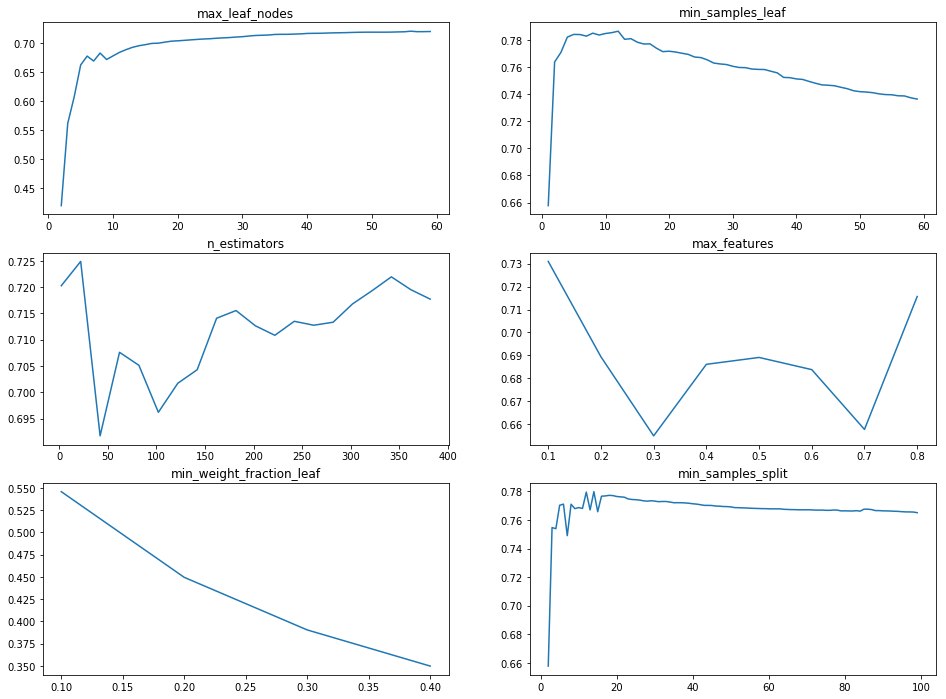

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

model_new = RandomForestRegressor(random_state=7)
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

## Grid Searching Hyper-parameters

In [ ]:
from sklearn.metrics import make_scorer


# define the grid search parameters
param_grid = { 
    'n_estimators': [300, 310, 320, 330,340,350],
    "max_depth": [3,4,5],
    "min_samples_split": np.arange(10,20,1),
    "min_samples_leaf": np.arange(10,14,1),
    "max_leaf_nodes": np.arange(10,20,1),
    "min_weight_fraction_leaf": [0.0],
    "max_features": [0.4,0.5,0.6]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(r2_score))
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#deatiled results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [30]:
##optimized model
#from sklearn.ensemble import RandomForestRegressor
## model with important features and max_features
#model2 = RandomForestRegressor(n_estimators=300, max_leaf_nodes=9,
#                               max_features='sqrt', min_samples_split = 57,
#                               min_weight_fraction_leaf =0.1, max_depth =4,
#                              min_samples_leaf=17,n_jobs=-1)
#
#model2.fit(X_train,Y_train)